In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import glob
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [2]:
files=glob.glob('../stock-data-dow-jones/*.csv')
#files=glob.glob('stock-data-dow-jones/*.txt')
df = pd.read_csv(files[28],index_col = 0)

In [3]:
df['log_return'] = [0.0]*df.shape[0]
for i in range(1,df.shape[0]):
    df['log_return'][i]=np.log(df['close'][i]/df['close'][i-1])*100

C:\Users\maxle\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
df.head()

,open,high,low,close,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,log_return
date,,,,,,,,,,,,
2014-06-12,66.5714,66.6939,66.1600,66.2913,5336596,5336596,-0.376406,-0.565,66.3323,"Jun 12, 14",0.000000,0.000000
2014-06-13,66.2387,66.3175,65.7573,65.8973,4981452,4981452,-0.393914,-0.594,65.9063,"Jun 13, 14",-0.005943,-0.596120
2014-06-16,65.7485,66.0724,65.6698,65.9499,3846878,3846878,0.052521,0.080,65.9065,"Jun 16, 14",-0.005150,0.079789
2014-06-17,65.9061,66.0199,65.5778,65.6435,6544215,6544215,-0.306376,-0.465,65.8109,"Jun 17, 14",-0.009772,-0.465678
2014-06-18,65.6873,66.4926,65.5822,66.2650,6740696,6740696,0.621509,0.947,66.1875,"Jun 18, 14",-0.000397,0.942327


In [5]:
df['volatility']=np.log(np.sqrt(pow((df['log_return']-df['log_return'].mean()),2)))

In [35]:
#df['volatility']=pow(df['log_return'],2)

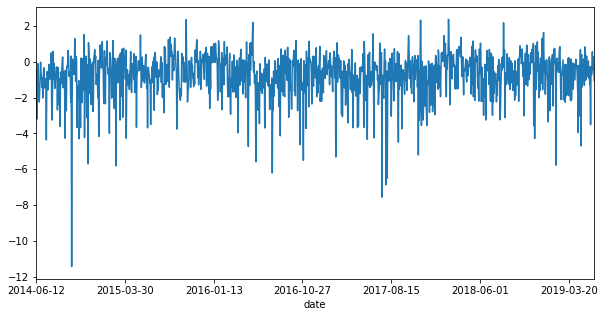

In [6]:
plt.figure(figsize = (10,5))
fg = df.volatility.plot()

In [223]:
'''
df_train = df['volatility'][df.index < "2017-03-01"]

df_val = df['volatility'][(df.index >= "2017-03-01") & (df.index < "2018-05-01")]

df_test = df['volatility'][df.index >= "2018-05-01"]

df_train = np.array(df_train).reshape(-1,1)
df_val = np.array(df_val).reshape(-1,1)
df_test = np.array(df_test).reshape(-1,1)
'''

In [7]:
# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1))
df_x = np.array(df.volatility).reshape(-1,1)
df_x = scaler1.fit_transform(df_x)

scaler2 = MinMaxScaler(feature_range=(0, 1))
df_y = np.array(df.volatility).reshape(-1,1)
df_y = scaler2.fit_transform(df_y)

In [8]:
def create_dataset(df_x, df_y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(df)-look_back):
        a = df_x[i:(i+look_back)]
        dataX.append(a)
        dataY.append(df_y[i+look_back])
    return np.array(dataX), np.array(dataY)
look_back = 10
data_X, data_Y = create_dataset(df_x, df_y, look_back)

In [9]:
data_X.shape

(1248, 10, 1)

In [10]:
# split into train and test sets
train_size = (int(len(df_y ) * 0.8) // 100) * 100
test_size = ((len(df_y) - train_size) // 100) * 100
df_x = df_x[:train_size+test_size]
df_y = df_y[:train_size+test_size]
data_X = data_X[:train_size+test_size]
data_Y = data_Y[:train_size+test_size]
trainX, testX = data_X[0:train_size], data_X[train_size:train_size + test_size]
trainY, testY = data_Y[0:train_size], data_Y[train_size:train_size + test_size]
trainX.shape

(1000, 10, 1)

In [11]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape((-1, look_back, 1))
testX = testX.reshape( (-1, look_back, 1))
trainY = trainY.reshape((-1, 1))
testY = testY.reshape( (-1, 1))


In [12]:
testX.shape

(200, 10, 1)

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(25, activation='relu', input_shape=(look_back, 1), return_sequences=False))
#model.add(LSTM(20, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=30, verbose=1)

Epoch 1/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1724
Epoch 2/30
1000/1000 [==============================] - 1s 688us/step - loss: 0.0110
Epoch 3/30
1000/1000 [==============================] - 1s 707us/step - loss: 0.0089
Epoch 4/30
1000/1000 [==============================] - 1s 719us/step - loss: 0.0089
Epoch 5/30
1000/1000 [==============================] - 1s 818us/step - loss: 0.0089
Epoch 6/30
1000/1000 [==============================] - 1s 735us/step - loss: 0.0090
Epoch 7/30
1000/1000 [==============================] - 1s 714us/step - loss: 0.0090
Epoch 8/30
1000/1000 [==============================] - 1s 755us/step - loss: 0.0092
Epoch 9/30
1000/1000 [==============================] - 1s 745us/step - loss: 0.0098
Epoch 10/30
1000/1000 [==============================] - 1s 745us/step - loss: 0.0089 0s - loss: 0.00
Epoch 11/30
1000/1000 [==============================] - 1s 755us/step - loss: 0.0091
Epoch 12/30
1000/1000 [==========================

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler2.inverse_transform(trainPredict)

trainY = scaler2.inverse_transform(trainY)
testPredict = scaler2.inverse_transform(testPredict)
testY = scaler2.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('R^2 train: %.3f' % (r2_score(trainY, trainPredict[:,0])))
print('R^2 test: %.3f' % (r2_score(trainY, trainPredict[:,0])))

Train Score: 1.28 RMSE
Test Score: 1.15 RMSE
R^2 train: -0.017
R^2 test: -0.017


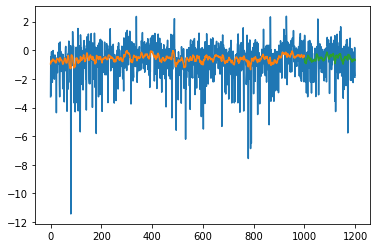

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_x)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0:len(trainPredict), :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_x)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):len(df_x), :] = testPredict
# plot baseline and predictions
#plt.figure(figsize=(100,5))
plt.plot(scaler2.inverse_transform(df_y))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
#plt.plot(df.log_return)
plt.show()